Install Spark and Java in Google Colab and set Enviroment Variables and Start Spark

In [44]:
# Install Spark and Java (only required in Google Colab)
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark

# Setup environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

# Start Spark
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("Hotel Booking Analysis").getOrCreate()

tar: spark-3.4.1-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


1. Start Spark Session and Load Dataset




In [45]:
from pyspark.sql import SparkSession

# Create a Spark session named "Hotel Booking Analysis"
spark = SparkSession.builder \
    .appName("Hotel Booking Analysis") \
    .getOrCreate()

In [46]:
# Read the CSV file into a Spark DataFrame
# - header=True: use the first row as column names
# - inferSchema=True: automatically detect data types for each column
df = spark.read.csv("egphotelbookings.csv", header=True, inferSchema=True)

# Print the schema of the DataFrame to inspect column names and data types
df.printSchema()

df.show(5)

root
 |-- _c0: integer (nullable = true)
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: double (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullable = true)

2. Preprocessing with DataFrame API

Explored the data using .describe() and value counts (groupBy("country").count()).

Dropped duplicate rows to eliminate redundancy.

Dropped rows with missing critical values: hotel, is_canceled, lead_time, and country.

Filled missing values in the children and babies columns with 0 to ensure accurate guest counts.

Identified and removed rows containing invalid (negative) values in adults, children, babies, and adr columns.

Detected and removed ambiguous categorical values in the meal column (specifically those labeled as "Undefined").

Dropped unused columns: agent, company, and days_in_waiting_list to simplify the dataset.

Created derived columns:

total_stay_duration: sum of weekday and weekend nights.

total_guests: sum of adults and babies (children handled via fill).

season: assigned based on arrival_date_month using conditional logic.

Registered the cleaned and transformed DataFrame as a temporary SQL view named "bookings" for use in SparkSQL queries.

In [60]:
from pyspark.sql.functions import col, when, isnan, count, sum as Fsum, expr, concat_ws, lit

# (a) Explore the data well and clean any noise
df.describe().show()
df.groupBy("country").count().orderBy("count", ascending=False).show(5)

# (b) Handle duplicates and missing values appropriately
df = df.dropDuplicates()
df = df.dropna(subset=["hotel", "is_canceled", "lead_time", "country"])
df = df.fillna({"children": 0, "babies": 0})

# Remove invalid or suspicious data
df.filter((col("adults") < 0) | (col("children") < 0) | (col("babies") < 0) | (col("adr") < 0)).show()
df = df.filter((col("adults") >= 0) &
               (col("children") >= 0) &
               (col("babies") >= 0) &
               (col("adr") >= 0))

# Handle ambiguous or undefined categorical values
df.filter(col("meal") == "Undefined").show()
df = df.filter(col("meal") != "Undefined")

# Drop unused columns
df = df.drop("agent", "company", "days_in_waiting_list")

# (c) Create new derived columns: Total stay duration, Season and Total guests
df = df.withColumn("total_stay_duration", col("stays_in_weekend_nights") + col("stays_in_week_nights")) \
       .withColumn("total_guests", col("adults") + col("babies")) \
       .withColumn("season", when(col("arrival_date_month").isin("December", "January", "February"), "Winter")
                   .when(col("arrival_date_month").isin("March", "April", "May"), "Spring")
                   .when(col("arrival_date_month").isin("June", "July", "August"), "Summer")
                   .otherwise("Fall"))

# Register the DataFrame as a temporary SQL view for SparkSQL queries
df.createOrReplaceTempView("bookings")

+-------+------------------+-----------------+-------------------+------------------+------------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------------------+-------------------+--------------------+------+-------+--------------------+-------------------+----------------------+------------------------------+------------------+------------------+-------------------+------------+---------------+------------------+---------------------------+-------------------------+-------------------+------------------+------+
|summary|               _c0|            hotel|        is_canceled|         lead_time| arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|            adults|           children|              babies|  meal|country|distribution_channel|  is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_t

 3. Implement Queries Twice: SparkSQL & DataFrame API

 a) Compute the cancellation rate as (number of cancellations / total bookings)*100 per country, and list the top five countries have the highest cancellation rates.

In [61]:
#SparkSQL:

spark.sql("""
    SELECT country,
           ROUND((SUM(is_canceled) / COUNT(*)) * 100, 2) AS cancellation_rate
    FROM bookings
    GROUP BY country
    ORDER BY cancellation_rate DESC
    LIMIT 5
""").show()

+-------+-----------------+
|country|cancellation_rate|
+-------+-----------------+
|    GGY|            100.0|
|    MYT|            100.0|
|    FJI|            100.0|
|    IMN|            100.0|
|    NIC|            100.0|
+-------+-----------------+



In [62]:
#DataFrame API:

df.groupBy("country") \
  .agg((Fsum("is_canceled") / count("*") * 100).alias("cancellation_rate")) \
  .orderBy("cancellation_rate", ascending=False) \
  .show(5)

+-------+-----------------+
|country|cancellation_rate|
+-------+-----------------+
|    MYT|            100.0|
|    UMI|            100.0|
|    GGY|            100.0|
|    VGB|            100.0|
|    JEY|            100.0|
+-------+-----------------+
only showing top 5 rows



The top five countries all show a 100% cancellation rate, likely due to very few bookings from each.



---



B) Identify which season (Winter, Spring, Summer, Fall) has the highest cancellation rate for bookings with lead time > 100 days. (Define seasons based on arrival_date_month)

In [50]:
#SparSQL:

spark.sql("""
    SELECT season,
           ROUND((SUM(is_canceled) / COUNT(*)) * 100, 2) AS cancel_rate
    FROM bookings
    WHERE lead_time > 100
    GROUP BY season
    ORDER BY cancel_rate DESC
    LIMIT 1
""").show()

+------+-----------+
|season|cancel_rate|
+------+-----------+
|Winter|      60.57|
+------+-----------+



In [51]:
#DataFrame API:
df.filter(col("lead_time") > 100) \
  .groupBy("season") \
  .agg((Fsum("is_canceled") / count("*") * 100).alias("cancel_rate")) \
  .orderBy("cancel_rate", ascending=False) \
  .show(1)

+------+-----------------+
|season|      cancel_rate|
+------+-----------------+
|Winter|60.57494866529775|
+------+-----------------+
only showing top 1 row



Winter has the highest cancellation rate (60.57%) for bookings made well in advance, indicating a stronger tendency to cancel during this season.


---



c) Which reserved room types experience the highest mismatch with the assigned room type?
(Where they differ).

In [52]:
#SparkSQL:

spark.sql("""
    SELECT reserved_room_type, assigned_room_type, COUNT(*) AS mismatches
    FROM bookings
    WHERE reserved_room_type != assigned_room_type
    GROUP BY reserved_room_type, assigned_room_type
    ORDER BY mismatches DESC
""").show()

+------------------+------------------+----------+
|reserved_room_type|assigned_room_type|mismatches|
+------------------+------------------+----------+
|                 A|                 D|      7360|
|                 A|                 C|      1347|
|                 A|                 B|      1120|
|                 A|                 E|      1092|
|                 D|                 E|       680|
|                 A|                 F|       401|
|                 E|                 F|       395|
|                 D|                 A|       312|
|                 A|                 K|       210|
|                 A|                 I|       209|
|                 D|                 F|       202|
|                 A|                 G|       182|
|                 F|                 G|       115|
|                 B|                 A|       111|
|                 E|                 G|       100|
|                 A|                 H|        89|
|                 D|           

In [53]:
#DataFrame API:

df.filter(col("reserved_room_type") != col("assigned_room_type")) \
  .groupBy("reserved_room_type", "assigned_room_type") \
  .count() \
  .orderBy("count", ascending=False) \
  .show()

+------------------+------------------+-----+
|reserved_room_type|assigned_room_type|count|
+------------------+------------------+-----+
|                 A|                 D| 7360|
|                 A|                 C| 1347|
|                 A|                 B| 1120|
|                 A|                 E| 1092|
|                 D|                 E|  680|
|                 A|                 F|  401|
|                 E|                 F|  395|
|                 D|                 A|  312|
|                 A|                 K|  210|
|                 A|                 I|  209|
|                 D|                 F|  202|
|                 A|                 G|  182|
|                 F|                 G|  115|
|                 B|                 A|  111|
|                 E|                 G|  100|
|                 A|                 H|   89|
|                 D|                 G|   81|
|                 D|                 I|   67|
|                 D|              

The most common mismatch is from reserved type 'A' to assigned type 'D', indicating frequent overbooking or reallocation of standard rooms.


---



d) Which distribution channel shows the lowest cancellation rate and what is its average revenue per booking (ADR x total nights)?

In [54]:
#SparkSQL:

spark.sql("""
    SELECT distribution_channel,
           ROUND((SUM(is_canceled) / COUNT(*)) * 100, 2) AS cancel_rate,
           ROUND(AVG(adr * total_stay_duration), 2) AS avg_revenue
    FROM bookings
    GROUP BY distribution_channel
    ORDER BY cancel_rate ASC
    LIMIT 1
""").show()

+--------------------+-----------+-----------+
|distribution_channel|cancel_rate|avg_revenue|
+--------------------+-----------+-----------+
|              Direct|       17.6|      371.5|
+--------------------+-----------+-----------+



In [55]:
#DataFrame API:

df.groupBy("distribution_channel") \
  .agg((Fsum("is_canceled") / count("*") * 100).alias("cancel_rate"),
       expr("avg(adr * total_stay_duration)").alias("avg_revenue")) \
  .orderBy("cancel_rate") \
  .show(1)

+--------------------+-----------------+------------------+
|distribution_channel|      cancel_rate|       avg_revenue|
+--------------------+-----------------+------------------+
|              Direct|17.60360233588968|371.49672694012526|
+--------------------+-----------------+------------------+
only showing top 1 row



The Direct distribution channel has the lowest cancellation rate (17.6%) and the highest average revenue, making it the most reliable and profitable booking method.


---



e) Which meal types are most common among bookings with more than 3 total guests?

In [56]:
#SparkSQL:

spark.sql("""
    SELECT meal, COUNT(*) AS count
    FROM bookings
    WHERE total_guests > 3
    GROUP BY meal
    ORDER BY count DESC
""").show()

+----+-----+
|meal|count|
+----+-----+
|  BB|   91|
|  HB|   14|
|  FB|    1|
+----+-----+



In [57]:
#DataFrame API:

df.filter(col("total_guests") > 3) \
  .groupBy("meal") \
  .count() \
  .orderBy("count", ascending=False) \
  .show()

+----+-----+
|meal|count|
+----+-----+
|  BB|   91|
|  HB|   14|
|  FB|    1|
+----+-----+



For bookings with more than 3 guests, the most commonly selected meal type is BB (Bed & Breakfast), indicating a clear preference for simpler meal plans among larger groups.


---



Bonus: Relation between lead time and cancellation status using a boxplot chart

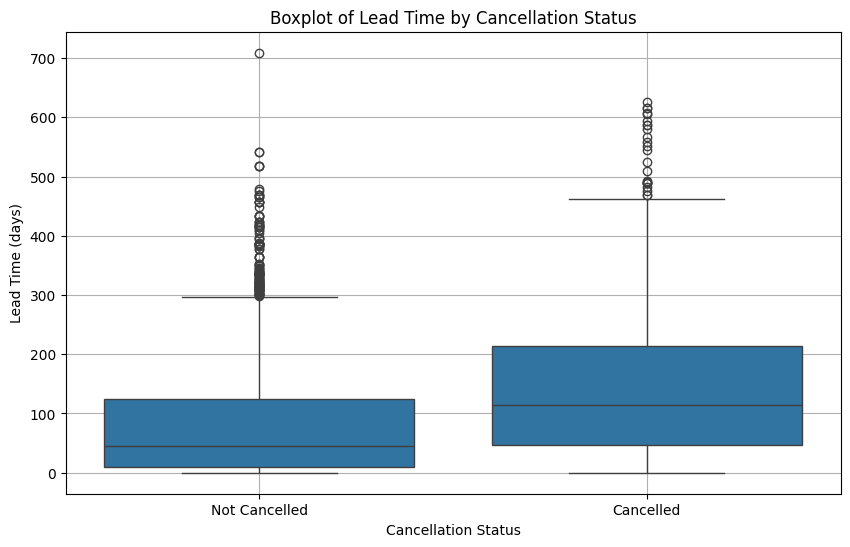

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample the data to reduce size for plotting
sample_df = df.select("lead_time", "is_canceled").sample(False, 0.05).toPandas()

# Convert cancellation to labeled form for clarity
sample_df["Cancellation Status"] = sample_df["is_canceled"].map({0: "Not Cancelled", 1: "Cancelled"})

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Cancellation Status", y="lead_time", data=sample_df)
plt.xlabel("Cancellation Status")
plt.ylabel("Lead Time (days)")
plt.title("Boxplot of Lead Time by Cancellation Status")
plt.grid(True)
plt.show()

**Trend Desciption:**

The boxplot clearly shows that cancelled bookings tend to have significantly higher lead times on average compared to non-cancelled bookings, indicating a strong association between longer lead times and likelihood of cancellation.
